In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
%matplotlib inline 
import sys, os 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
#import warnings library
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
# Any results you write to the current directory are saved as output.
import pygraphviz
from causalnex.structure import StructureModel
from sklearn.preprocessing import LabelEncoder
from causalnex.structure.notears import from_pandas
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV

In [5]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_read import FileHandler
# from exploration import Exploration
filehandler = FileHandler()

In [6]:
# reading data
data = filehandler.read_csv('../input/data.csv')

## Preparing the Data for Structure Learning
### since id doesn't have significance for the output we will drop it out and also unnamed column is nan

In [31]:
# y includes our labels and x includes our features
le = LabelEncoder()
data["diagnosis"] = le.fit_transform(data["diagnosis"])
y = data.diagnosis                          # M or B 
list = ['Unnamed: 32','id','diagnosis']
x = data.drop(list,axis = 1 )

### Splitting data into training and test set for feature selection

In [34]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(n_estimators = 100,random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

### using Recursive feature elimination with cross validation and random forest classification, we will find how many features do we need for best accuracy.

In [35]:
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

Optimal number of features : 11
Best features : Index(['perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean',
       'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
       'area_worst', 'concavity_worst', 'concave points_worst'],
      dtype='object')


### so we will be using this number of feature for our causal graph

## Structure from Domain Knowledge
### We can manually define a structure model by specifying the relationships between different features.

### First, we must create an empty structure model.

In [22]:
sm = StructureModel()
sm = from_pandas(x)

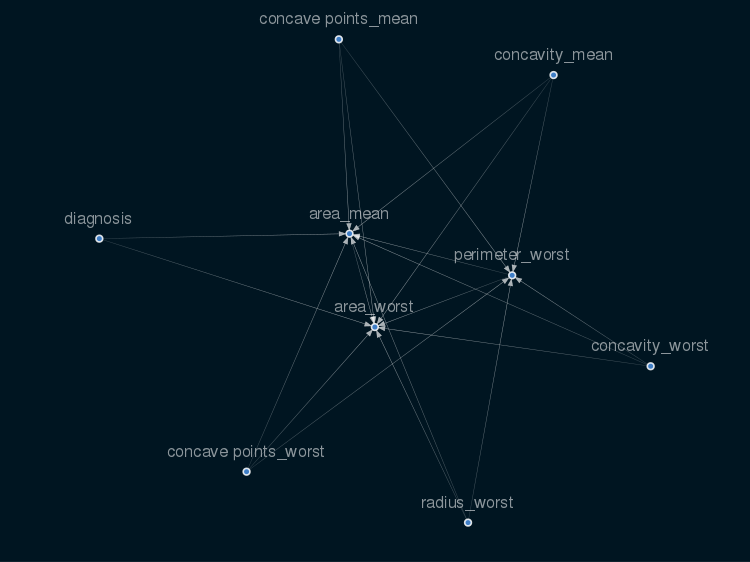

In [24]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2.0","size": "2.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))